In [24]:

# Importing libraries
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm  # For progress bar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
)
import matplotlib.pyplot as plt
import spacy


In [ ]:
#importing data
data = pd.read_csv('WELFake_Dataset.csv')

In [ ]:
#Filling NA spaces
data = data.fillna(' ')

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       72134 non-null  object
 2   text        72134 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                      
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary al

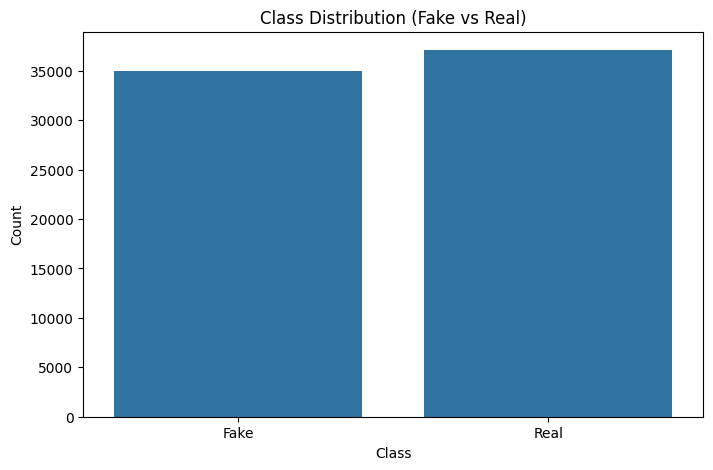

In [ ]:
import seaborn as sns


#inspecting data
print("Dataset Overview:")
print(data.info())  # Overview of data structure
print(data.head())  # First few rows

#Class Distributions
print("Class Distribution:")
class_counts = data['label'].value_counts()
print(class_counts)

# Plotting Class Distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution (Fake vs Real)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Fake', 'Real'])
plt.show()

Text Length Statistics:
count    72134.000000
mean       540.550933
std        625.399748
min          0.000000
25%        227.000000
50%        398.000000
75%        667.000000
max      24234.000000
Name: text_length, dtype: float64


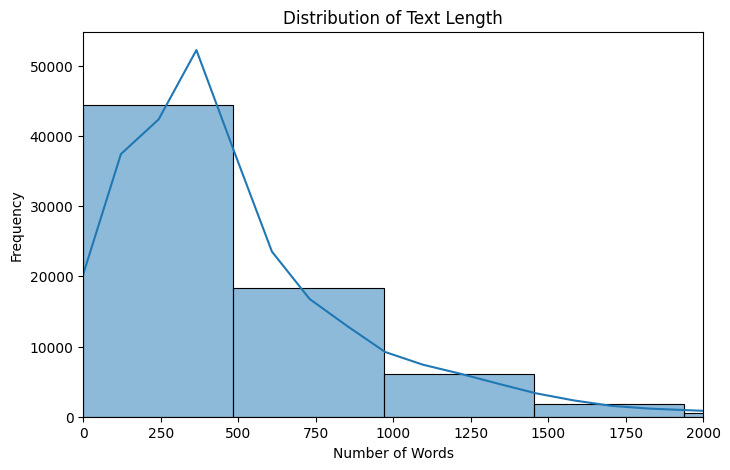

In [ ]:
# Plotting text characteristics like length of posts
data['text_length'] = data['text'].apply(lambda x: len(x.split()))  # Word count
print("Text Length Statistics:")
print(data['text_length'].describe())


plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")


plt.xlim(0, 2000)

plt.show()


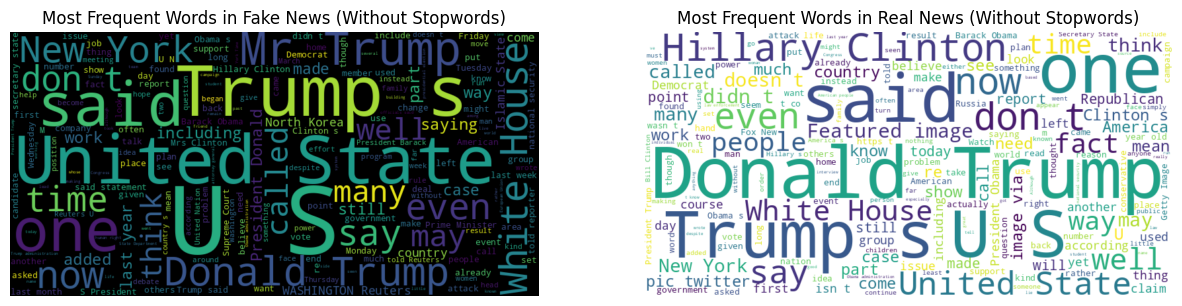

In [ ]:
#https://www.datacamp.com/tutorial/wordcloud-python?
from wordcloud import WordCloud, STOPWORDS


#generating word clouds with stopwords filtered out
fake_text = " ".join(
    [word for word in " ".join(data[data['label'] == 0]['text']).split() if word.lower() not in custom_stopwords]
)
real_text = " ".join(
    [word for word in " ".join(data[data['label'] == 1]['text']).split() if word.lower() not in custom_stopwords]
)


wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)

# Plotting
plt.figure(figsize=(15, 7))


plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Most Frequent Words in Fake News (Without Stopwords)")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("Most Frequent Words in Real News (Without Stopwords)")
plt.axis("off")

plt.show()


In [ ]:
#https://spacy.io/usage/processing-pipelines?utm
import spacy
import pandas as pd
from nltk.corpus import stopwords
from tqdm import tqdm  # progress bar
import nltk
nltk.download('stopwords')

# Loading the spaCy model, disabling unnecessary components
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
stop_words = set(stopwords.words('english'))

def lemmatization_spacy_batch(content, batch_size=500):
    """Lemmatizes content in batches using spaCy with a progress bar."""
    lemmatized_content = []

    #Converting any non strings to strings
    content = [str(text) for text in content]
    for doc in tqdm(nlp.pipe(content, batch_size=batch_size), total=len(content)):
        lemmatized_content.append(" ".join([token.lemma_ for token in doc if token.text.lower() not in stop_words and token.is_alpha]))
    return lemmatized_content

#this chunk takes over an hour to run if using the whole dataset, but it performs slightly better than stemming

#combining all the dataset's text data into one
data['content'] = data['title'].fillna('') + ' ' + data['text'].fillna('')

# Lemmatizing new column
data['lemmatized_content'] = lemmatization_spacy_batch(data['content'].tolist())





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 72134/72134 [1:09:08<00:00, 17.39it/s]


In [ ]:
# Saving the dataset to a CSV file so I don't have to rerun that chunk of code that takes really long
data.to_csv('lemmatized_welfake.csv', index=False)
print("Dataset saved as lemmatized_welfake.csv")

Dataset saved as lemmatized_welfake.csv


In [ ]:
# Load CSV
data = pd.read_csv('lemmatized_welfake.csv')

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizing

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # unigrams and bigrams
    stop_words='english',
    min_df=200,
    max_df=0.90,
)

# Filling NaN values in the dataset with an empty string
data['lemmatized_content'] = data['lemmatized_content'].fillna("")

# Assigning X and y variables
X = vectorizer.fit_transform(data['lemmatized_content'])
y = data['label']


# Train, test, and validation split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# i tried word2vec, leaving in numerical values and removing named entities
# during the lematization , all of which severely diminished the accuracy of my
# model. named entities makes sense because news is usually about named entities
# using min/max_df was helpfful and improved the model by about 1 percent



In [18]:
#12

# Training Logistic Regression for tuning
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)



LogisticRegression()

F1 Score (Validation): 0.9435


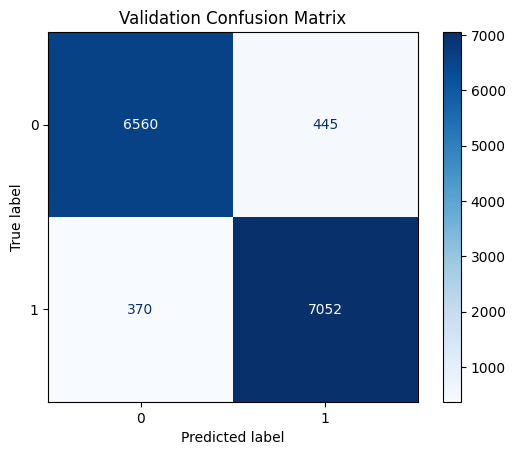

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

#testing untuned regression on val data
y_val_pred = model.predict(X_val)

#confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)

# f1 score
f1_val = f1_score(y_val, y_val_pred, average='weighted')
print(f"F1 Score (Validation): {f1_val:.4f}")

# Plotting the confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=model.classes_)


disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()


In [20]:
#https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/
#https://medium.com/@arnavr/scikit-learn-solvers-explained-780a17bc322d


from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.linear_model import LogisticRegression

#Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10],  # Reduced range otherwise it takes a really long time
    'solver': ['liblinear'], #i should try saga - was never able to get it to run, will proceed with liblinear
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)



# this takes a while but does seem to improves the model by about 3 percentage
# points. edit: only by about 2 points when adding min/max_df to vectorizing


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


Classification Report for Validation Data:
              precision    recall  f1-score   support

           0     0.9633    0.9525    0.9579      7005
           1     0.9556    0.9658    0.9607      7422

    accuracy                         0.9593     14427
   macro avg     0.9595    0.9591    0.9593     14427
weighted avg     0.9594    0.9593    0.9593     14427

F1 Score for Validation Data: 0.9593


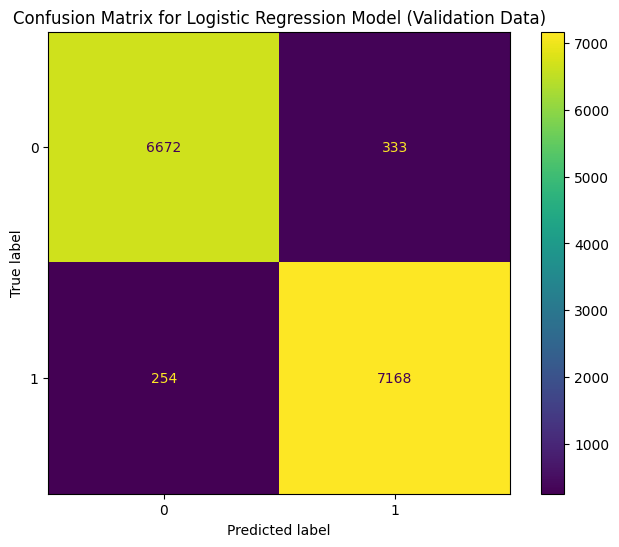

In [25]:
#https://scikit-learn.org/stable/modules/grid_search.html

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Import the matplotlib library and assign it to the alias 'plt'

# Evaluating the best model from Grid Search on val data
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
print("Classification Report for Validation Data:")
print(classification_report(y_val, y_pred_val, digits=4))

val_f1_score = classification_report(y_val, y_pred_val, digits=4, output_dict=True)['weighted avg']['f1-score']
print(f"F1 Score for Validation Data: {val_f1_score:.4f}")

#confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm_val).plot(ax=ax)
plt.title("Confusion Matrix for Logistic Regression Model (Validation Data)")
plt.show()



Classification Report for Test Data:
              precision    recall  f1-score   support

           0     0.9602    0.9542    0.9572      7006
           1     0.9570    0.9627    0.9598      7421

    accuracy                         0.9585     14427
   macro avg     0.9586    0.9584    0.9585     14427
weighted avg     0.9586    0.9585    0.9585     14427

F1 Score for Test Data: 0.9585


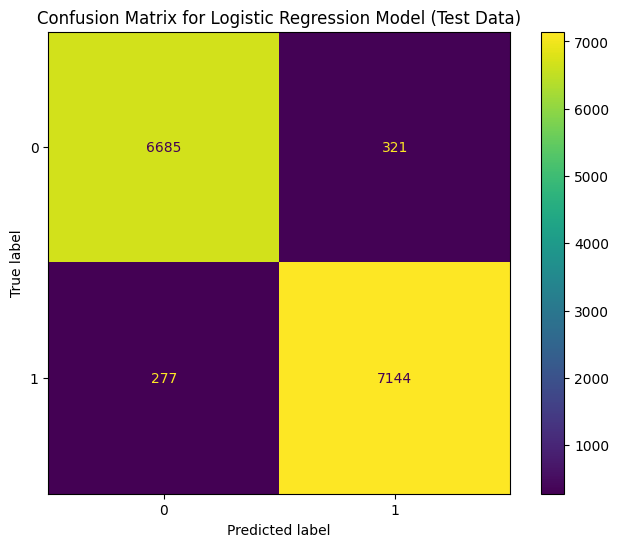

In [26]:
#trying on the test set
y_pred_test = best_model.predict(X_test)
print("Classification Report for Test Data:")
print(classification_report(y_test, y_pred_test, digits=4))

test_f1_score = classification_report(y_test, y_pred_test, digits=4, output_dict=True)['weighted avg']['f1-score']
print(f"F1 Score for Test Data: {test_f1_score:.4f}")


cm_test = confusion_matrix(y_test, y_pred_test)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm_test).plot(ax=ax)
plt.title("Confusion Matrix for Logistic Regression Model (Test Data)")
plt.show()


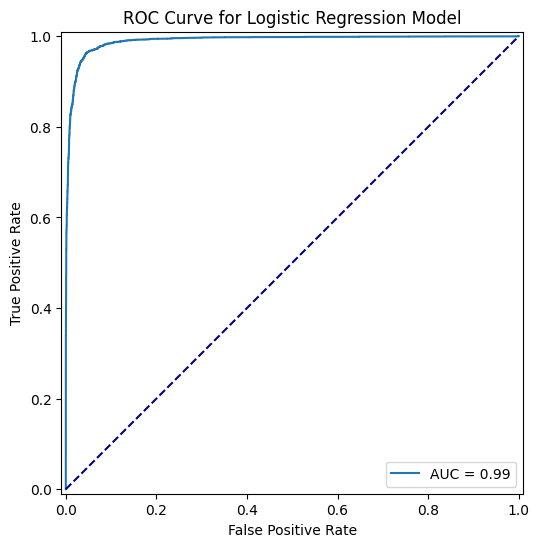

In [ ]:

#plotting ROC curve

from sklearn.metrics import roc_curve, auc, RocCurveDisplay


y_prob = best_model.predict_proba(X_test)[:, 1]

#roc curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculating the AUC
roc_auc = auc(fpr, tpr)

#Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax)
plt.title("ROC Curve for Logistic Regression Model")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--") # Add reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


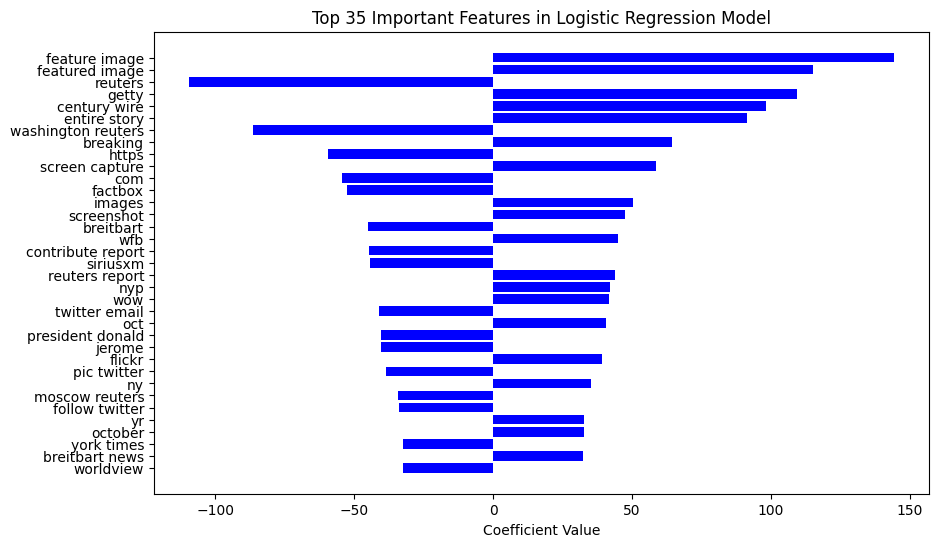

In [ ]:
#most important coeficients (not proportional)
#https://realpython.com/logistic-regression-python/?
feature_names = vectorizer.get_feature_names_out()
coefficients = best_model.coef_[0]



sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = feature_names[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Plotting the top x features for better visualization
top_n = 35
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:top_n], sorted_coefficients[:top_n], color='blue')
plt.xlabel("Coefficient Value")
plt.title("Top 35 Important Features in Logistic Regression Model")
plt.gca().invert_yaxis()
plt.show()

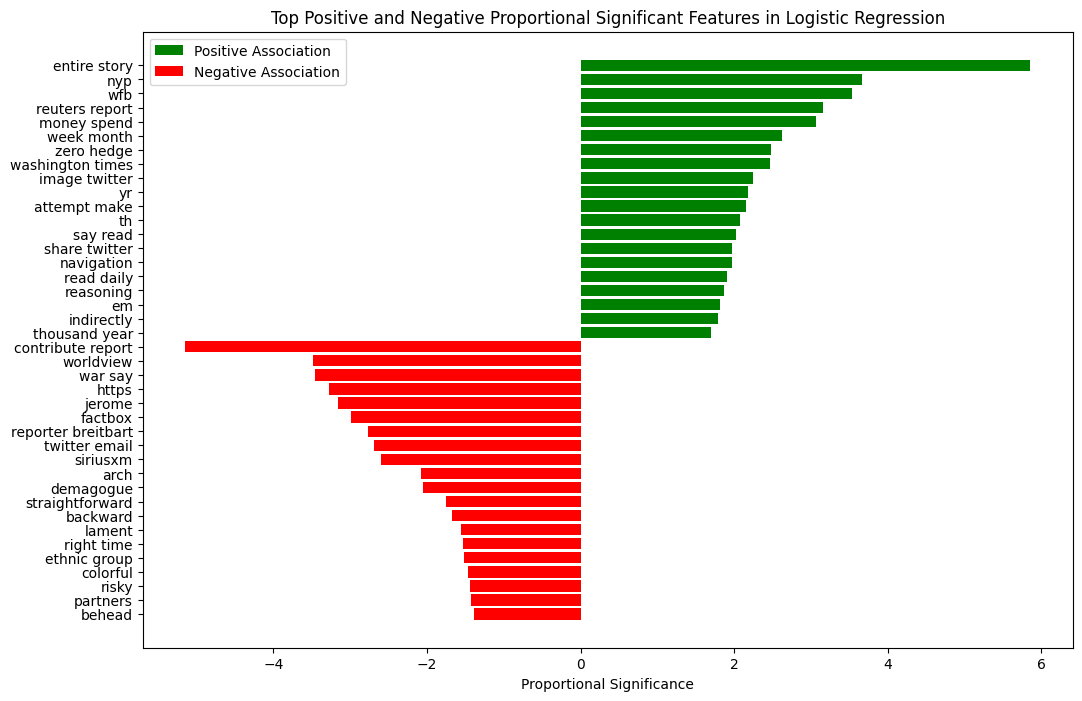

In [23]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#https://machinelearningmastery.com/calculate-feature-importance-with-python/

#plotting coefs by proportional signifigance
feature_names = vectorizer.get_feature_names_out()


coefficients = best_model.coef_[0]

term_frequencies = X_train.sum(axis=0).A1

# Calculating proportional significance (coefficient / term frequency)
proportional_significance = coefficients / (term_frequencies + 1e-6)


positive_indices = np.argsort(proportional_significance)[::-1]
negative_indices = np.argsort(proportional_significance)

top_n = 20
top_positive_features = [feature_names[i] for i in positive_indices[:top_n]]
top_positive_values = proportional_significance[positive_indices[:top_n]]

top_negative_features = [feature_names[i] for i in negative_indices[:top_n]]
top_negative_values = proportional_significance[negative_indices[:top_n]]

plt.figure(figsize=(12, 8))


plt.barh(top_positive_features, top_positive_values, color='green', label='Positive Association')


plt.barh(top_negative_features, top_negative_values, color='red', label='Negative Association')


plt.xlabel("Proportional Significance")
plt.title("Top Positive and Negative Proportional Significant Features in Logistic Regression")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


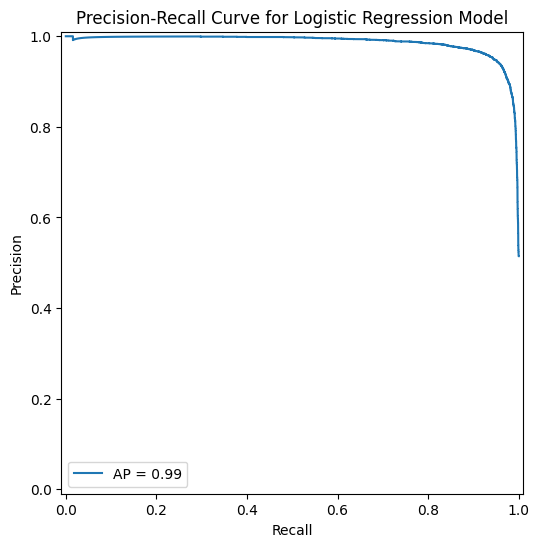

In [ ]:

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

#Plotting precision-recall curve
y_prob = best_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob)


average_precision = average_precision_score(y_test, y_prob)

fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision).plot(ax=ax)
plt.title("Precision-Recall Curve for Logistic Regression Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()